# Input Processing

In [94]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import posixpath
import wfdb
import data
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read all records 

In [95]:
dataset_name = 'afdb'

samples, labels = data.read_records(dataset_name, '../data/files/', batch_size=1)
print(len(samples), len(labels))

23 23


In [96]:
# dict_labels = {'[\'(N\']': 0, 
#                '[\'(AFIB\']': 1,
#                '[\'(AFIB\', \'(N\']': 0,
#                '[]': 0,
#                '[\'(AFL\']': 0}
labels_formatted = np.array([1 if '(AFIB' in key else 0 for key in labels])
print(labels_formatted)

tp = labels_formatted.sum()
total = len(labels_formatted)
print('Positive cases: {}'.format(tp))
print('Total cases: {}'.format(total))
print('Positive weight: {}%'.format(100 * tp / total))

[0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
Positive cases: 4
Total cases: 23
Positive weight: 17.391304347826086%


In [97]:
record = samples[10]
display(record.__dict__)

{'record_name': '06426',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 7500,
 'base_time': datetime.time(9, 0),
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.055,  0.13 ],
        [-0.07 ,  0.075],
        [-0.09 ,  0.09 ],
        ...,
        [-0.1  ,  0.37 ],
        [-0.12 ,  0.37 ],
        [-0.12 ,  0.375]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['06426.dat', '06426.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-11, 26],
 'checksum': [45981, 2866],
 'block_size': [0, 0]}

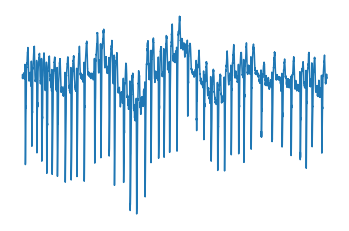

In [98]:
plt.axis('off')
plt.plot(np.arange(record.sig_len), record.p_signal.T[0]) # Select by argmax(SQI)
fig = plt.show()
# 432 × 288

## Wavelet transform

Wavelet decomposition:

[-0.055 -0.07  -0.09  ... -0.1   -0.12  -0.12 ]
[   8.33          8.72396004    9.13655208    9.5686573    10.02119855
   10.49514235   10.9915009    11.51133429   12.05575275   12.625919
   13.22305076   13.84842335   14.50337238   15.18929666   15.90766112
   16.66         17.44792009   18.27310416   19.13731459   20.0423971
   20.99028469   21.98300179   23.02266858   24.1115055    25.251838
   26.44610153   27.6968467    29.00674477   30.37859332   31.81532224
   33.32         34.89584017   36.54620832   38.27462919   40.0847942
   41.98056938   43.96600359   46.04533716   48.22301099   50.503676
   52.89220305   55.3936934    58.01348954   60.75718664   63.63064448
   66.64         69.79168034   73.09241665   76.54925838   80.1695884
   83.96113876   87.93200717   92.09067432   96.44602198  101.00735199
  105.7844061   110.7873868   116.02697908  121.51437328  127.26128897
  133.28        139.58336069  146.18483329  153.09851675  160.33917681
  167.92227753  175.86401435  184.1813

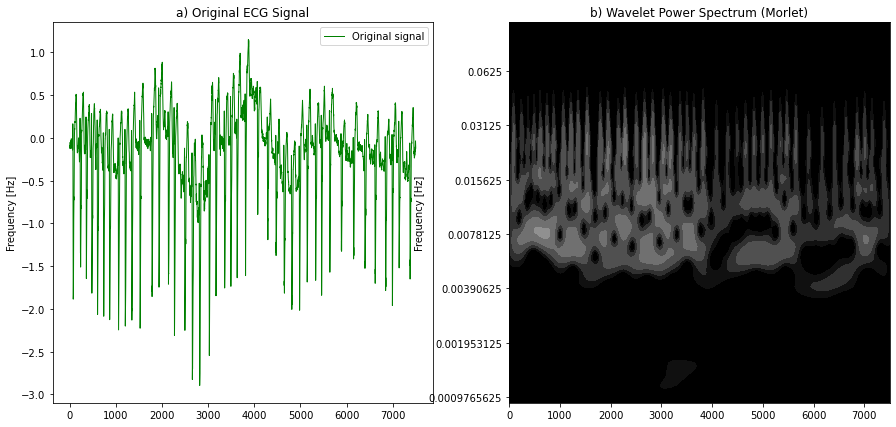

In [105]:
import dsp

signal = record.p_signal.T[0]
print(signal)
time, frequencies, power = dsp.wavelet_decompose_power_spectrum(signal)
dsp.plot_wavelet_decomposition(time, signal, frequencies, power, wavelet_name='Morlet')

## Label mapping

In [ ]:
# wfdb.show_ann_labels()

In [ ]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

data = fig2rgb_array(fig)
# img = Image.fromarray(data, 'RGB')
# img.save('test.png')
# img.show()

# fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

In [ ]:
original = 
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(data_path + record_name, sampto = sampto)
annotation = wfdb.rdann(data_path + record_name, 'atr', sampto = sampto)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record '+ record_name  +' from MIT-BIH Arrhythmia Database',
               time_units='seconds')

## ECG Processing

In [ ]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path + record_name, sampfrom=0, sampto=sampto, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record" + record_name)
    

In [ ]:
# Use the XQRS detection algorithm and compare results to reference annotations
import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(data_path + record_name, channels=[0], sampto=sampto)
ann_ref = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the QRS indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected QRS complexes to reference annotation.
# Note, first sample in 100.atr is not a QRS.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected QRS vs reference annotations')